In [1]:
#| default_exp segmentation.core

# segmentation core

> API details.

In [2]:
#|hide
from nbdev.showdoc import *

In [3]:
#|export
#TODO: optimize imports
import polvo
from fastai.vision.all import *

In [4]:
data_dir = untar_data(URLs.CAMVID_TINY)

In [5]:
image_files = get_image_files(data_dir/'images')

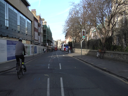

In [6]:
image_file = image_files[0]
PILImage.create(image_file)

<AxesSubplot:>

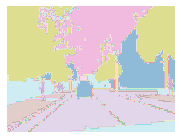

In [7]:
mask_files = get_image_files(data_dir/'labels')
mask_file = mask_files[0]
PILMask.create(mask_file).show()

In [8]:
def image2mask(image_file):
    return (image_file.parent.parent/f'labels/{image_file.stem}_P').with_suffix('.png')

In [9]:
x_pipe = [PILImage.create]
y_pipe = [image2mask, PILMask.create]

splits = RandomSplitter(seed=42)(image_files)

x_tl = TfmdLists(image_files, x_pipe)
y_tl = TfmdLists(image_files, y_pipe)
dss = Datasets(image_files, [x_pipe, y_pipe], splits=splits)

<AxesSubplot:>

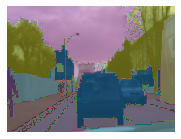

In [10]:
dss.show(dss[1])

In [11]:
#|export
# TODO: Move DataExplorer base either to common or core
class SegmentationExplorer(polvo.classification.DataExplorer):
    def __init__(self, x_tl, y_tl, id2label):
        self.x_tl = x_tl
        self.y_tl = y_tl
        self.id2label = id2label
        
        self.grouped_y = self._group_y()
        
        
    def _group_y(self):
        label_stats = []
        for item_idx, y in enumerate(progress_bar(self.y_tl)):
            labels, counts = np.unique(y, return_counts=True)
            label_stats.extend([{'item_idx': item_idx,
                                 'label_id': l,
                                 'pct': c / counts.sum(),
                                 'count': c,
                                 'label': self.id2label[l]} 
                                for l, c in zip(labels, counts)])
        
        grouped_y = pd.DataFrame(label_stats)
        grouped_y = grouped_y.groupby("label_id").agg({'label': 'first',
                                                       'item_idx': list,
                                                       'pct': list,
                                                       'count': sum}).reset_index()
        grouped_y["n_samples"] = grouped_y.item_idx.str.len()
        grouped_y = grouped_y.sort_values("count", ascending=False).reset_index(drop=True)
        return grouped_y
    
    def most_common_appearances(self):
        "Return a dafarame ordered by the number of appearances of a label in the dataset."
        return self.grouped_y.sort_values('n_samples', ascending=False).reset_index(drop=True)
    
    def most_common_pixels(self):
        "Return a dataframe ordered by the most common pixels in the dataset."
        return self.most_common()

    @classmethod
    def from_datasets(cls, dss, id2label):
        return cls(dss.tls[0], dss.tls[1], id2label)

In [12]:
codes = (data_dir/'codes.txt').read_text().strip('\n').split('\n')

In [13]:
exp = SegmentationExplorer.from_datasets(dss, codes)

In [14]:
exp.most_common()

,label_id,label,item_idx,pct,count,n_samples
0,17,Road,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]","[0.3201497395833333, 0.11800130208333333, 0.3297526041666667, 0.2720540364583333, 0.2618815104166667, 0.2600911458333333, 0.26953125, 0.23274739583333334, 0.2542317708333333, 0.2872721354166667, 0.3677571614583333, 0.2958984375, 0.3177897135416667, 0.31591796875, 0.3347981770833333, 0.250732421875, 0.2899576822916667, 0.13818359375, 0.12483723958333333, 0.259765625, 0.2556966145833333, 0.23779296875, 0.254638671875, 0.30078125, 0.2620442708333333, 0.2691243489583333, 0.16194661458333334, 0.377685546875, 0.20784505208333334, 0.2001953125, 0.3341471354166667, 0.32421875, 0.2569173177083333, ...",333377,100
1,4,Building,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]","[0.200927734375, 0.035888671875, 0.19417317708333334, 0.3678385416666667, 0.177734375, 0.292236328125, 0.3058268229166667, 0.2738444010416667, 0.20751953125, 0.20442708333333334, 0.328857421875, 0.38427734375, 0.08390299479166667, 0.17724609375, 0.09700520833333333, 0.3037923177083333, 0.4156901041666667, 0.23616536458333334, 0.4112141927083333, 0.3087565104166667, 0.3045247395833333, 0.3534342447916667, 0.3087565104166667, 0.047688802083333336, 0.2631022135416667, 0.19327799479166666, 0.18465169270833334, 0.2987467447916667, 0.09724934895833333, 0.4130045572916667, 0.175537109375, 0.32600...",295563,99
2,21,Sky,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]","[0.08121744791666667, 0.24308268229166666, 0.17081705729166666, 0.08634440104166667, 0.101806640625, 0.19783528645833334, 0.10782877604166667, 0.100341796875, 0.233642578125, 0.22159830729166666, 0.10652669270833333, 0.12947591145833334, 0.17708333333333334, 0.09212239583333333, 0.1025390625, 0.137939453125, 0.11116536458333333, 0.16153971354166666, 0.14396158854166666, 0.12044270833333333, 0.11775716145833333, 0.14021809895833334, 0.08935546875, 0.049886067708333336, 0.21272786458333334, 0.09537760416666667, 0.2732747395833333, 0.08260091145833333, 0.18522135416666666, 0.217041015625, 0.0...",186143,100
3,26,Tree,"[0, 1, 2, 4, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 94, 95, 98, 99]","[0.18229166666666666, 0.228759765625, 0.13387044270833334, 0.18701171875, 0.045003255208333336, 0.11759440104166667, 0.035400390625, 0.021158854166666668, 0.042887369791666664, 0.233642578125, 0.183837890625, 0.286376953125, 0.024495442708333332, 0.014729817708333334, 0.14835611979166666, 0.017415364583333332, 0.046793619791666664, 0.047607421875, 0.04052734375, 0.09847005208333333, 0.0322265625, 0.046875, 0.186279296875, 0.11458333333333333, 0.3116861979166667, 0.006429036458333333, 0.168701171875, 0.027425130208333332, 0.18009440104166666, 0.07

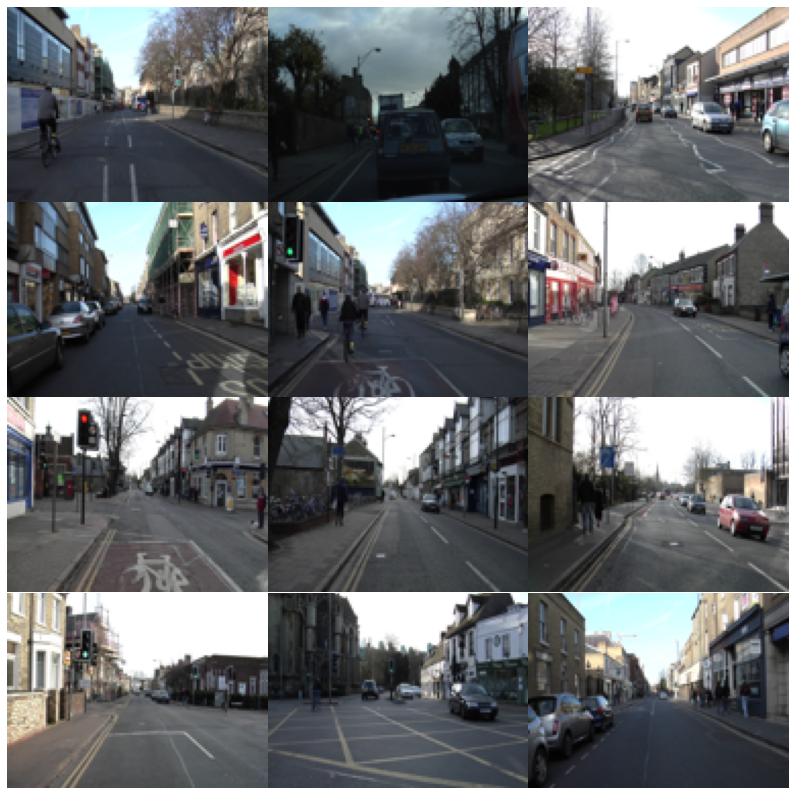

(<Figure size 1008x1152 with 24 Axes>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x7f5cd715e0d0>)

In [15]:
exp.show_most_common(0, slice_=slice(0, 12))

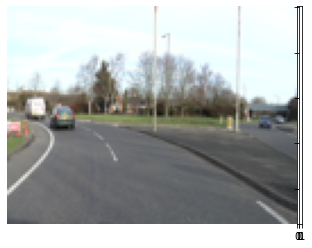

(<Figure size 1008x288 with 6 Axes>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x7f5cd68b9190>)

In [16]:
exp.show_label_id(23)

## TODO: Test working!

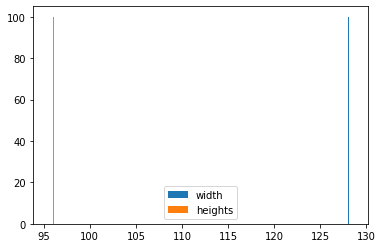

In [17]:
polvo.image_sizes_hist(image_files)

In [18]:
after_item = [ToTensor(), Resize(128), AddMaskCodes(codes)]
after_batch = [IntToFloatTensor(), *aug_transforms(size=64, min_scale=0.75, max_rotate=150)]
dls = dss.dataloaders(32, after_item=after_item, after_batch=after_batch, num_workers=0)

/home/lgvaz/miniconda3/envs/fastai/lib/python3.7/site-packages/torch/_tensor.py:1121: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [19]:
#|export
show_tfms = polvo.show_tfms

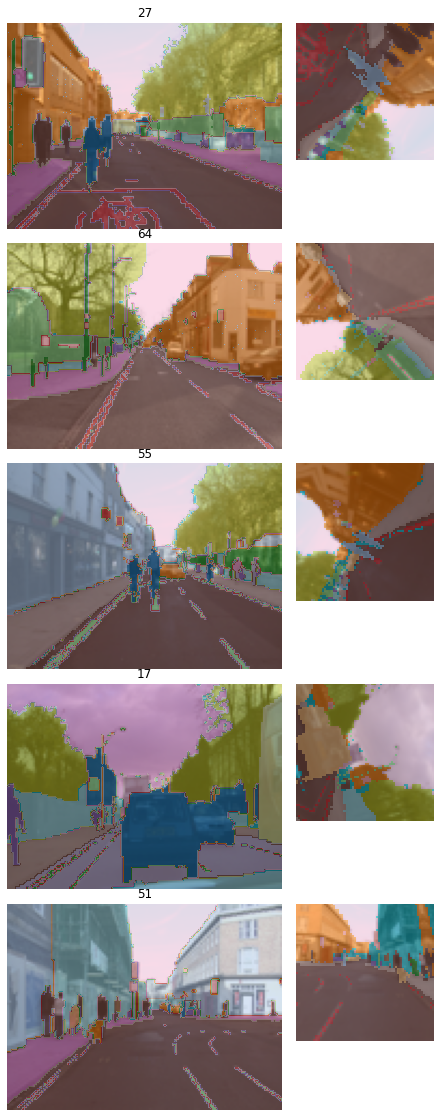

(<Figure size 1008x1440 with 20 Axes>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x7f5da8f1ad90>)

In [20]:
show_tfms(dls.train, unique_idx=None)

In [26]:
#| hide
from nbdev import nbdev_export
nbdev_export()